In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier

from catboost import CatBoostClassifier

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

import kagglehub

ModuleNotFoundError: No module named 'yellowbrick'

In [3]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [4]:
from yellowbrick.classifier import ConfusionMatrix, ROCAUC

In [5]:
train_df = pd.read_csv("train.csv")
train_df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [6]:
path = kagglehub.dataset_download("chilledwanker/loan-approval-prediction")

100%|██████████| 368k/368k [00:00<00:00, 2.63MB/s]

Extracting files...


In [9]:
train_df_complement = pd.read_csv(f'{path}/credit_risk_dataset.csv')
train_df_complement.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [10]:
train_df = train_df.drop(labels='id', axis=1)
train_df = pd.concat([train_df, train_df_complement], ignore_index=True)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91226 entries, 0 to 91225
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 8.4+ MB


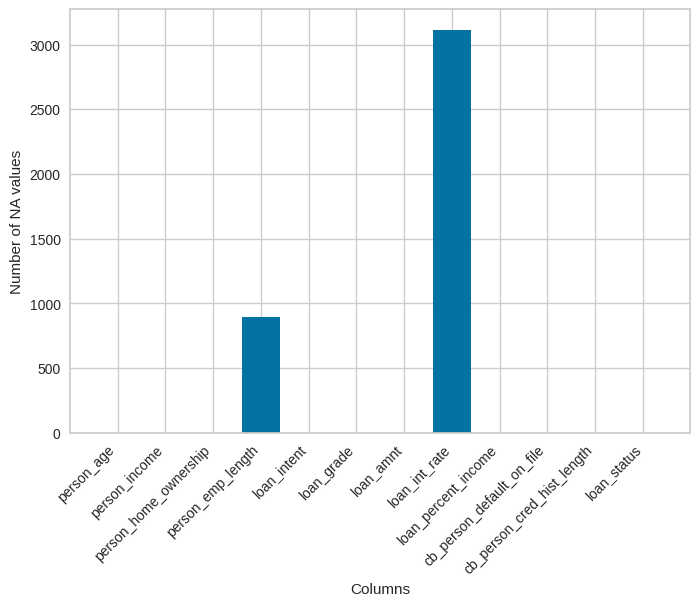

In [12]:
#Check the missing values across the table
plt.bar(train_df.isna().sum().index, train_df.isna().sum().values)
plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of NA values')
plt.show()

In [13]:
train_df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

#### First let's dig in the data and take care of NA values

In [14]:
train_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,91226.000000,9.122600e+04,90331.000000,91226.000000,88110.000000,91226.000000,91226.000000,91226.000000
mean,27.616480,6.477071e+04,4.732119,9350.348607,10.789508,0.163154,5.810219,0.169447
std,6.148115,4.793696e+04,4.025068,5848.605423,3.108998,0.097491,4.038412,0.375149
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.000000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.700000e+04,4.000000,8000.000000,10.950000,0.140000,4.000000,0.000000
75%,30.000000,7.800000e+04,7.000000,12000.000000,13.110000,0.220000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


#### We see values in the 'age' and 'person_emp_length' that are not realistic ie over 100 years

In [15]:
train_df = train_df[train_df.person_age < 100]
train_df = train_df[train_df.person_emp_length < 100]

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90321 entries, 0 to 91225
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  90321 non-null  int64  
 1   person_income               90321 non-null  int64  
 2   person_home_ownership       90321 non-null  object 
 3   person_emp_length           90321 non-null  float64
 4   loan_intent                 90321 non-null  object 
 5   loan_grade                  90321 non-null  object 
 6   loan_amnt                   90321 non-null  int64  
 7   loan_int_rate               87274 non-null  float64
 8   loan_percent_income         90321 non-null  float64
 9   cb_person_default_on_file   90321 non-null  object 
 10  cb_person_cred_hist_length  90321 non-null  int64  
 11  loan_status                 90321 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.0+ MB


In [17]:
train_df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length                0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3047
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

#### Now we only have missing values in the 'loan_int_rate'

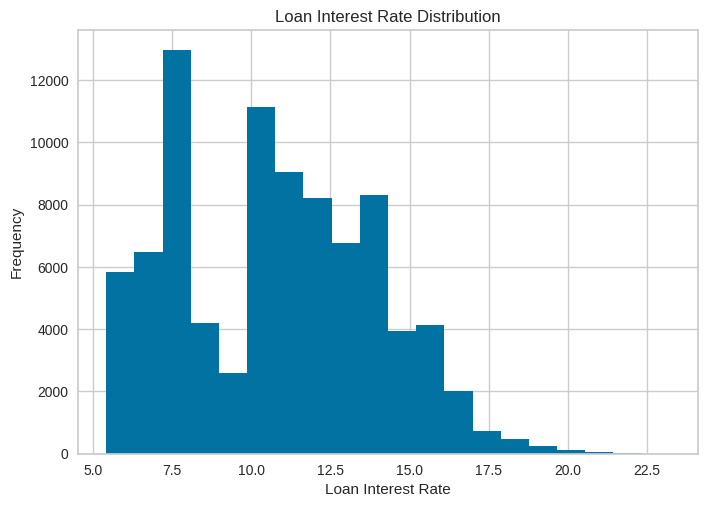

In [18]:
#Check the distribution
plt.hist(train_df['loan_int_rate'].dropna(), bins=20)
plt.title('Loan Interest Rate Distribution')
plt.xlabel('Loan Interest Rate')
plt.ylabel('Frequency')
plt.show()

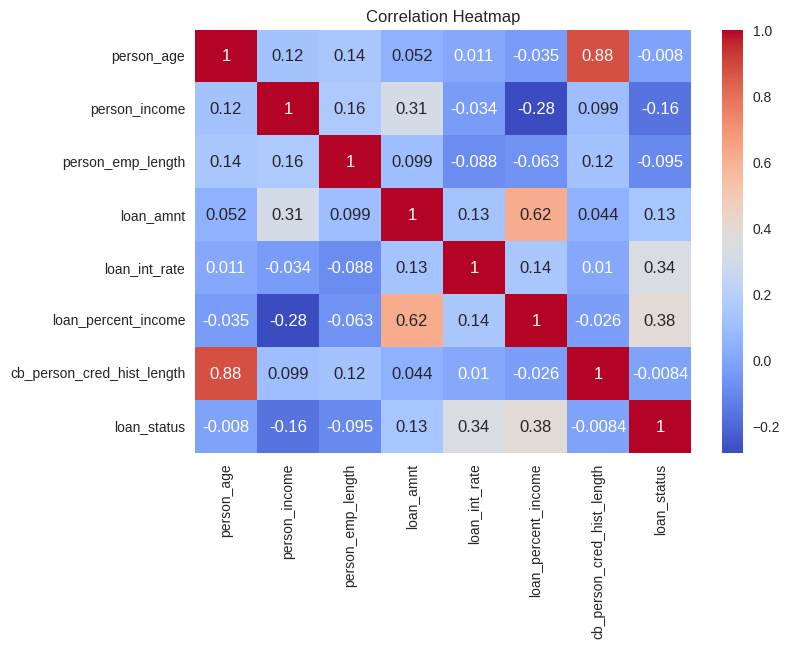

In [19]:
#Heatmap to check any correlation with other numerical features
numerical_features = train_df.select_dtypes(include=['float64', 'int64']).columns
sns.heatmap(train_df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

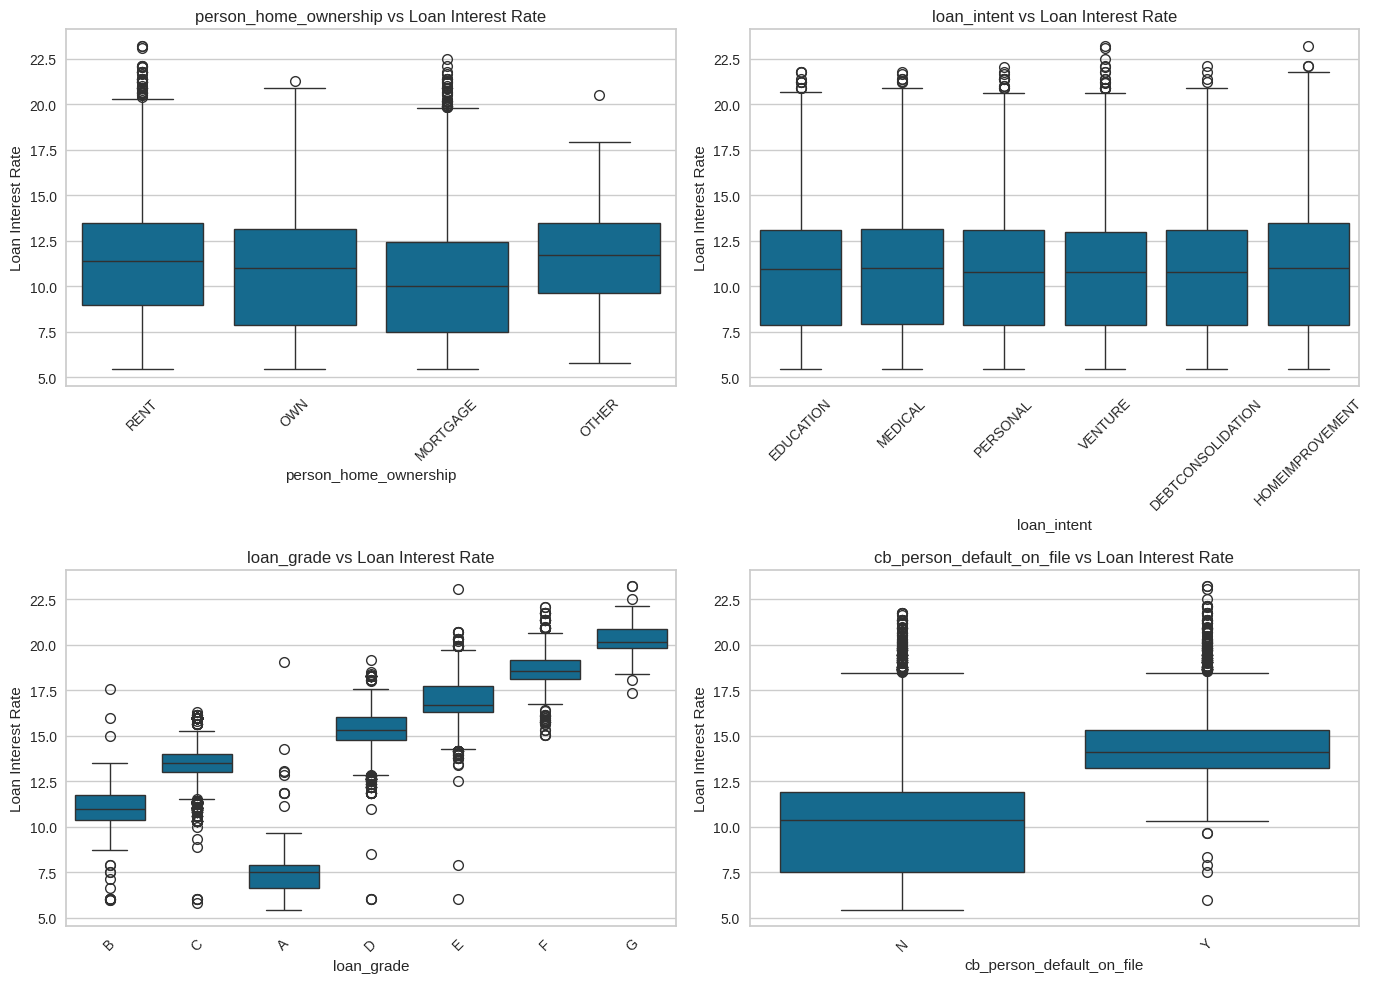

In [20]:
#Boxplots to check any correlation with categorical features
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

#Create a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#Flatten the axes array for easy iteration
axes = axes.flatten()

#Loop through each categorical feature and create a boxplot
for i, feature in enumerate(categorical_features):
    sns.boxplot(
        x=feature,
        y='loan_int_rate',
        data=train_df,
        ax=axes[i]
    )
    axes[i].set_title(f'{feature} vs Loan Interest Rate', fontsize=12)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Loan Interest Rate')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [21]:
#We can see a positive correlation between 'loan_grade' and 'loan_int_rate'
#To fill NA values, we're gonna use the median for each loan_grade since the distribution is skewed and bimodal

num_feature = 'loan_int_rate'
cat_feature = 'loan_grade'

#Calculate the median interest rate for each loan grade
group_medians = train_df.groupby(cat_feature)[num_feature].median()

#Fill missing values
train_df[num_feature] = train_df.apply(
    lambda row: group_medians[row[cat_feature]] if pd.isnull(row[num_feature]) else row[num_feature],
    axis=1
)

In [22]:
train_df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

#### The goal is to apply an xgboost gradient, a random forest and a catboost which are common for this type of problems. 
#### xgboost and random forest take numeric values as an entry thus we're gonna have to modify 4 features into numeric values : 'person_home_ownership', 'loan_intent', 'loan_grade' and 'cb_person_default_on_file'
#### catboost has its own encoding when specified categorical features

In [19]:
#'person_home_ownership' has 4 different values
train_df['person_home_ownership'].value_counts()

person_home_ownership
RENT        46666
MORTGAGE    37911
OWN          5548
OTHER         196
Name: count, dtype: int64

In [20]:
#'loan_intent' has 6 different values
train_df['loan_intent'].value_counts()

loan_intent
EDUCATION            18559
MEDICAL              16830
VENTURE              15563
PERSONAL             15382
DEBTCONSOLIDATION    14197
HOMEIMPROVEMENT       9790
Name: count, dtype: int64

In [21]:
#'loan_grade' has 7 different values
train_df['loan_grade'].value_counts()

loan_grade
A    31354
B    30581
C    17355
D     8588
E     1961
F      385
G       97
Name: count, dtype: int64

In [22]:
#'cb_person_default_on_file' has 2 different values
train_df['cb_person_default_on_file'].value_counts()

cb_person_default_on_file
N    75992
Y    14329
Name: count, dtype: int64

In [23]:
X = train_df.drop(labels='loan_status', axis=1)
y = train_df['loan_status']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

cat_model = CatBoostClassifier(verbose=0, random_state=42)

param_dist_catboost = {
    'iterations': [100, 200, 500],            
    'learning_rate': [0.01, 0.05, 0.1],       
    'depth': [4, 6, 8],                       
    'l2_leaf_reg': [1, 3, 5,],                  
    'border_count': [32, 64, 128],                
    'random_strength': [1, 5, 10],                
    'bagging_temperature': [0.5, 1, 2, 3],        
    'scale_pos_weight': [1, 2, 3]                
}

random_search_catboost = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist_catboost,
    n_iter=40,                 
    cv=3,                      
    scoring='accuracy',        
    n_jobs=-1,                 
    random_state=42,           
    verbose=2                  
)

random_search_catboost.fit(X_train, y_train, cat_features=categorical_features)

best_params_catboost = random_search_catboost.best_params_
print("Best Parameters:", best_params_catboost)

cat_model = CatBoostClassifier(**best_params_catboost, verbose=0, random_state=42)
cat_model.fit(X_train, y_train, cat_features=categorical_features)

y_pred = cat_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best Parameters: {'scale_pos_weight': 1, 'random_strength': 1, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 6, 'border_count': 128, 'bagging_temperature': 0.5}
Accuracy on Test Set: 0.9494049266537503


In [25]:
cat_model.fit(X, y, cat_features=categorical_features)

In [27]:
X = train_df.drop(labels='loan_status', axis=1)
y = train_df['loan_status']

In [28]:
#In order to get numeric values we're gonna use a LabelEncoder for each feature
columns_to_encode = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

#Store the specific encoders
label_encoders = {}

#Label Encoding on the 4 columns
for column in columns_to_encode:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

In [29]:
scaler = MinMaxScaler(feature_range = (0, 1))
X = scaler.fit_transform(X)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [100, 200, 500, 1000],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', objective = "binary:logistic")

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  
    scoring='accuracy',  
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

best_params_xgb = random_search.best_params_

print("Best parameters:", best_params_xgb)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bagging_temperature=3, border_count=32, depth=8, iterations=500, l2_leaf_reg=5, learning_rate=0.01, random_strength=10, scale_pos_weight=2; total time= 1.6min
[CV] END bagging_temperature=2, border_count=64, depth=4, iterations=200, l2_leaf_reg=1, learning_rate=0.01, random_strength=10, scale_pos_weight=2; total time=  28.6s
[CV] END bagging_temperature=2, border_count=64, depth=8, iterations=200, l2_leaf_reg=5, learning_rate=0.05, random_strength=1, scale_pos_weight=2; total time=  48.9s
[CV] END bagging_temperature=0.5, border_count=32, depth=6, iterations=500, l2_leaf_reg=5, learning_rate=0.01, random_strength=10, scale_pos_weight=2; total time= 1.4min
[CV] END bagging_temperature=2, border_count=32, depth=4, iterations=100, l2_leaf_reg=3, learning_rate=0.1, random_strength=10, scale_pos_weight=2; total time=   6.0s
[CV] END bagging_temperature=2, border_count=32, depth=4, iterations=100, l2_leaf_reg=3, learning_

In [32]:
xgb_model = XGBClassifier(**best_params_xgb, random_state=42)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    early_stopping_rounds=10,
    verbose=True
)

[0]	validation_0-auc:0.86010
[1]	validation_0-auc:0.86437
[2]	validation_0-auc:0.90998
[3]	validation_0-auc:0.91644
[4]	validation_0-auc:0.91684
[5]	validation_0-auc:0.91679
[6]	validation_0-auc:0.91886
[7]	validation_0-auc:0.92015
[8]	validation_0-auc:0.92070
[9]	validation_0-auc:0.92218
[10]	validation_0-auc:0.92342
[11]	validation_0-auc:0.92535
[12]	validation_0-auc:0.92558
[13]	validation_0-auc:0.92818
[14]	validation_0-auc:0.92933


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-auc:0.93102
[16]	validation_0-auc:0.93400
[17]	validation_0-auc:0.93426
[18]	validation_0-auc:0.93537
[19]	validation_0-auc:0.93686
[20]	validation_0-auc:0.93751
[21]	validation_0-auc:0.93879
[22]	validation_0-auc:0.94066
[23]	validation_0-auc:0.94082
[24]	validation_0-auc:0.94256
[25]	validation_0-auc:0.94324
[26]	validation_0-auc:0.94335
[27]	validation_0-auc:0.94358
[28]	validation_0-auc:0.94365
[29]	validation_0-auc:0.94365
[30]	validation_0-auc:0.94415
[31]	validation_0-auc:0.94457
[32]	validation_0-auc:0.94475
[33]	validation_0-auc:0.94499
[34]	validation_0-auc:0.94570
[35]	validation_0-auc:0.94672
[36]	validation_0-auc:0.94694
[37]	validation_0-auc:0.94783
[38]	validation_0-auc:0.94812
[39]	validation_0-auc:0.94835
[40]	validation_0-auc:0.94849
[41]	validation_0-auc:0.94879
[42]	validation_0-auc:0.94896
[43]	validation_0-auc:0.94929
[44]	validation_0-auc:0.94943
[45]	validation_0-auc:0.94956
[46]	validation_0-auc:0.94967
[47]	validation_0-auc:0.94967
[48]	valid

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [33]:
predictions = xgb_model.predict(X_test)
proba_predictions = xgb_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, predictions))
print("ROC-AUC:", roc_auc_score(y_test, proba_predictions))

Accuracy: 0.9481317464710767
ROC-AUC: 0.9579734496776455


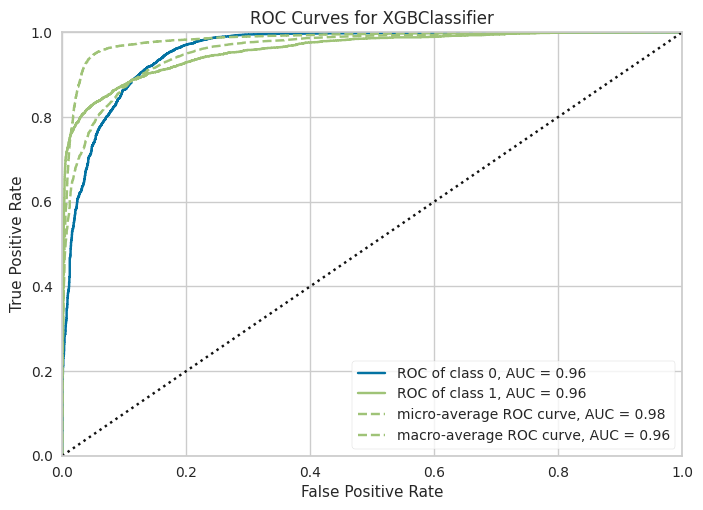

In [34]:
visualizer = ROCAUC(xgb_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

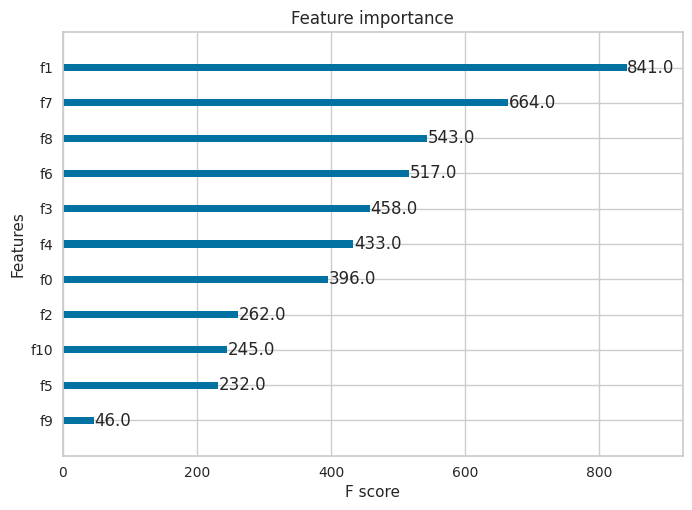

In [35]:
xgb.plot_importance(xgb_model)
plt.show()

In [36]:
rf = RandomForestClassifier(random_state=42)

#Parameter Grid for RandomizedSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],     
    'max_depth': [None, 10, 20, 30],     
    'min_samples_split': [2, 5, 10],     
    'min_samples_leaf': [1, 2, 4],       
    'max_features': ['sqrt', 'log2'],    
    'bootstrap': [True, False]           
}

#Initialize RandomizedSearch
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    cv=3,                   
    n_jobs=-1,              
    scoring='accuracy',     
    verbose=2               
)

#Fit RandomizedSearchCV
random_search_rf.fit(X_train, y_train)

#Best Parameters
best_params_rf = random_search_rf.best_params_
print("Best Parameters:", best_params_rf)

#Train Random Forest with Best Parameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=42)
best_rf.fit(X_train, y_train)

#Evaluate Model
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
Accuracy: 0.9470246332687517


In [37]:
xgb_model.fit(X, y)
rf.fit(X, y)

RandomForestClassifier(random_state=42)

In [38]:
# Define and train Voting Classifier with Random Forest xgboost and CatBoost to get the best of all three models
voting_model = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('XGBoost', xgb_model),
        ('CatBoost', cat_model)
    ],
    voting='soft'
)

voting_model.fit(X, y)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.1,
                                            grow_policy=None,
                                            importance_t...
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('CatBoost',
                              <catboost.core.CatBoostClassifier object at 0x7bdaea9be0b0>)],
                 voting='soft')

In [39]:
test_df = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")
test = test_df.drop(labels=['id'], axis=1)

In [40]:
#Make the final prediction
for col, le in label_encoders.items():
    if col in test_df.columns:
        test[col] = le.transform(test[col])

test = scaler.fit_transform(test)

predictions = voting_model.predict(test)

predictions = [0 if pred <= 0.5 else 1 for pred in predictions]

submission_df = pd.DataFrame({'id' : test_df['id'], 'class' : predictions})
submission_df.to_csv('submission.csv', index=False)

[CV] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=   7.1s
[CV] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=1000, reg_alpha=0.1, reg_lambda=1.5, subsample=0.7; total time=   7.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, n_estimators=200, reg_alpha=0.1, reg_lambda=2, subsample=0.5; total time=   1.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=3, n_estimators=200, reg_alpha=0.1, reg_lambda=2, subsample=0.5; total time=   1.7s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.3, max_depth=